## 1. Dependencies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import datetime

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 2. Data

#### 2.1 Load Data

Firstly, the data was given in a .txt format which represents a json file. However, even if the capability of pandas to recognize a json, our data doesn't fit in the dataframe.

In [4]:
df = pd.read_json('sample.txt',orient='records')

Notice above how badly structured is the data for our imported libraries. To solve this, let's analysis each json property to get more relevant data.

In [5]:
df.head()

,complemento,dets,emit,ide,infAdic,total,versaoDocumento
0,{'valorTotal': 24.9},"[{'nItem': '1', 'prod': {'indTot': '1', 'qCom'...","{'cnpj': '01.234.567/0001-89', 'enderEmit': {'...",{'dhEmi': {'$date': '2016-01-05T12:01:54.000Z'...,{'infCpl': 'Mesa 2'},"{'icmsTot': {'vDesc': 0.0, 'vFrete': 0.0, 'vOu...",1
1,{'valorTotal': 92.53},"[{'nItem': '1', 'prod': {'indTot': '1', 'qCom'...","{'cnpj': '01.234.567/0001-89', 'enderEmit': {'...",{'dhEmi': {'$date': '2016-01-05T12:03:52.000Z'...,{'infCpl': 'Mesa 1'},"{'icmsTot': {'vDesc': 0.0, 'vFrete': 0.0, 'vOu...",1
2,{'valorTotal': 57.86},"[{'nItem': '1', 'prod': {'indTot': '1', 'qCom'...","{'cnpj': '01.234.567/0001-89', 'enderEmit': {'...",{'dhEmi': {'$date': '2016-01-05T12:16:40.000Z'...,{'infCpl': 'Mesa 5'},"{'icmsTot': {'vDesc': 0.0, 'vFrete': 0.0, 'vOu...",1
3,{'valorTotal': 34.97},"[{'nItem': '1', 'prod': {'indTot': '1', 'qCom'...","{'cnpj': '01.234.567/0001-89', 'enderEmit': {'...",{'dhEmi': {'$date': '2016-01-05T12:17:50.000Z'...,{'infCpl': 'Mesa 3'},"{'icmsTot': {'vDesc': 0.0, 'vFrete': 0.0, 'vOu...",1
4,{'valorTotal': 46.23},"[{'nItem': '1', 'prod': {'indTot': '1', 'qCom'...","{'cnpj': '01.234.567/0001-89', 'enderEmit': {'...",{'dhEmi': {'$date': '2016-01-05T12:18:35.000Z'...,{'infCpl': 'Mesa 4'},"{'icmsTot': {'vDesc': 0.0, 'vFrete': 0.0, 'vOu...",1


#### 2.2 Preprocess

###### 2.2.1 valorTotal

To start, let's get the order total price and remove it from the json dataframe.

In [6]:
df['valorTotal'] = df['complemento'].map(lambda x: x['valorTotal'])

###### 2.2.2 date

From the "ide" object, the date parameter is extracted.

In [7]:
raw_dates = df['ide'].map(lambda x: x['dhEmi']['$date'])
dates = raw_dates.apply(lambda x: pd.to_datetime(x))
df['date'] = dates

It's evident that the days of this dataset only represent the orders during the period of days 5 and 23 of January 2016

In [8]:
print(df['date'].min())
print(df['date'].max())

2016-01-05 12:01:54
2016-01-23 14:56:35


###### 2.2.3 natOp

natOp only has the categorical data "VENDA" which wont be used in the data analysis due to be the only unique value in each cell.

In [9]:
table = df['infAdic'].map(lambda x: x['infCpl'])
table = table.str.extract('(\d?\d)', expand =False)
df['Table'] = pd.to_numeric(table)

###### 2.2.4 Products Ordered

Above, the function get_order_df is built in order to extract the sum of every item ordered in the order.

In [10]:
def get_order_df(df):
    orderList =[]
    buffetList=[]
    for i in range(len(df['dets'])):
        order= []
        buffetKg=[]
        for j in range(len(df['dets'].values[i])):
            if(df['dets'].values[i][j]['prod']['xProd'] != 'BUFFET'):
                order.append(df['dets'].values[i][j]['prod']['xProd'])
            else:
                buffetKg.append(df['dets'].values[i][j]['prod']['qCom'])
        if(len(order) == 0):
            orderList.append(['NO ADDITIONAL'])
        else:
            orderList.append(order)
        buffetList.append(buffetKg)
    s = pd.Series(orderList)
    s = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
    b = pd.Series(buffetList,name='Buffet_Kg')
    b = b.apply(lambda x: x[0])
    s = s.join(b)
    cols = s.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    return s.reindex(cols, axis=1)

In [11]:
orders = get_order_df(df)

In [12]:
#orders['BUFFET'].unique()

In [13]:
#orders = orders.drop('BUFFET',axis=1)

###### 2.2.5 Get BUFFET KG

###### 2.2.6 Remove json inherited columns

The unstructured columns are removed as they are not going to be needed anymore.

In [14]:
df = df.drop(['ide'], axis=1)
df = df.drop(['complemento'], axis=1)
df = df.drop(['infAdic'], axis=1)
df = df.drop(['versaoDocumento'], axis=1)
df = df.drop(['emit'], axis=1)
df = df.drop(['total'], axis=1)
df = df.drop(['dets'], axis=1)

#### 2.3 Merge DataFrames

To Finish this session, the final dataframe is built.

In [15]:
closedOrders = df.join(orders)
closedOrders = closedOrders.set_index('date')

In [16]:
closedOrders.describe()

,valorTotal,Table,Buffet_Kg,AGUA,BACARDI,BULE CHA,CAFE EXPRESSO,CAIPIRINHA,CAIPIROSKA,CERVEJA,...,SAKE,SASHIMI,SOBREMESA,SUCO,SUSHI ESPECIAL,TEMAKI,URAMAKI,VINHO,WHISKY,YAKISSOBA
count,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,...,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000,1635.000000
mean,55.504171,46.097859,0.673403,0.255046,0.000612,0.004893,0.012232,0.004281,0.005505,0.056881,...,0.022018,0.001835,0.010398,0.112538,0.028135,0.008563,0.000612,0.000612,0.009786,0.002446
std,39.217462,29.096033,0.427472,0.452550,0.024731,0.069800,0.109955,0.065312,0.074011,0.236910,...,0.146788,0.042809,0.107330,0.336747,0.179599,0.092166,0.024731,0.024731,0.098469,0.060547
min,9.740000,1.000000,0.112000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.985000,21.000000,0.386000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,43.260000,43.000000,0.534000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,69.230000,71.000000,0.853000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,608.910000,99.000000,4.896000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,2.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [17]:
closedOrders.head()

,valorTotal,Table,Buffet_Kg,AGUA,BACARDI,BULE CHA,CAFE EXPRESSO,CAIPIRINHA,CAIPIROSKA,CERVEJA,...,SAKE,SASHIMI,SOBREMESA,SUCO,SUSHI ESPECIAL,TEMAKI,URAMAKI,VINHO,WHISKY,YAKISSOBA
date,,,,,,,,,,,,,,,,,,,,,
2016-01-05 12:01:54,24.90,2,0.312,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-05 12:03:52,92.53,1,1.218,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-05 12:16:40,57.86,5,0.778,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2016-01-05 12:17:50,34.97,3,0.510,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-05 12:18:35,46.23,4,0.674,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
closedOrders['Drinks'] = closedOrders[['BACARDI','CAIPIRINHA','CAIPIROSKA','CERVEJA','CERVEJA LATA','SAKE','VINHO','WHISKY']].sum(axis=1)
closedOrders['Oriental'] = closedOrders[['HARUMAKI','SASHIMI','SUSHI ESPECIAL','TEMAKI','URAMAKI','YAKISSOBA']].sum(axis=1)
closedOrders['Non Alcoholic'] = closedOrders[['AGUA','BULE CHA','CAFE EXPRESSO','CHA','LIMONADA','REFRIGERANTE','SUCO']].sum(axis=1)

#### 3. Data Visualization

###### 3.1 Restaurant Income

As seen in the result and plot below, it's clear that restaurant opens for lunch between 11AM and 15:30PM and opens for dinner between 19PM and 23:40 PM

In [19]:
closedOrders[(closedOrders.index.time > datetime.time(15, 24, 30)) & (closedOrders.index.time < datetime.time(18, 59, 0))].index

DatetimeIndex(['2016-01-18 18:57:28', '2016-01-22 15:24:46'], dtype='datetime64[ns]', name='date', freq=None)

In [20]:
closedOrders.index.time.max()

datetime.time(23, 40, 48)

[Text(0,0.5,'R$'), Text(0.5,0,'Days')]

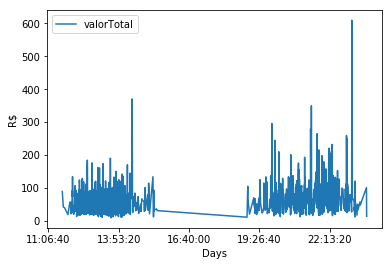

In [21]:
plot1 = closedOrders.plot(x=closedOrders.index.time,y=['valorTotal'])
plot1.set(xlabel="Days", ylabel='R$')

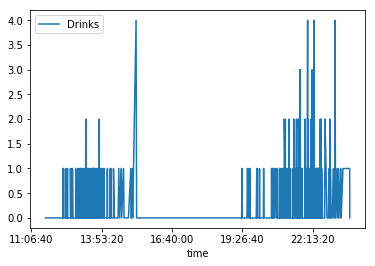

In [22]:
plot1 = closedOrders.plot(x=closedOrders.index.time,y=['Drinks'])

Also, we can plot the montly income

[Text(0,0.5,'R$'), Text(0.5,0,'Days')]

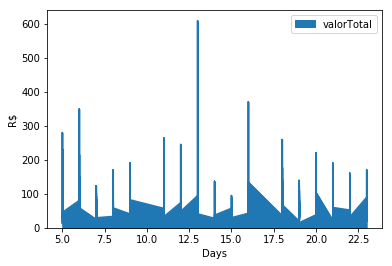

In [23]:
closedOrders.plot(x=closedOrders.index.day,y=['valorTotal'],kind='area').set(xlabel="Days", ylabel='R$')

###### 3.2 Correlation

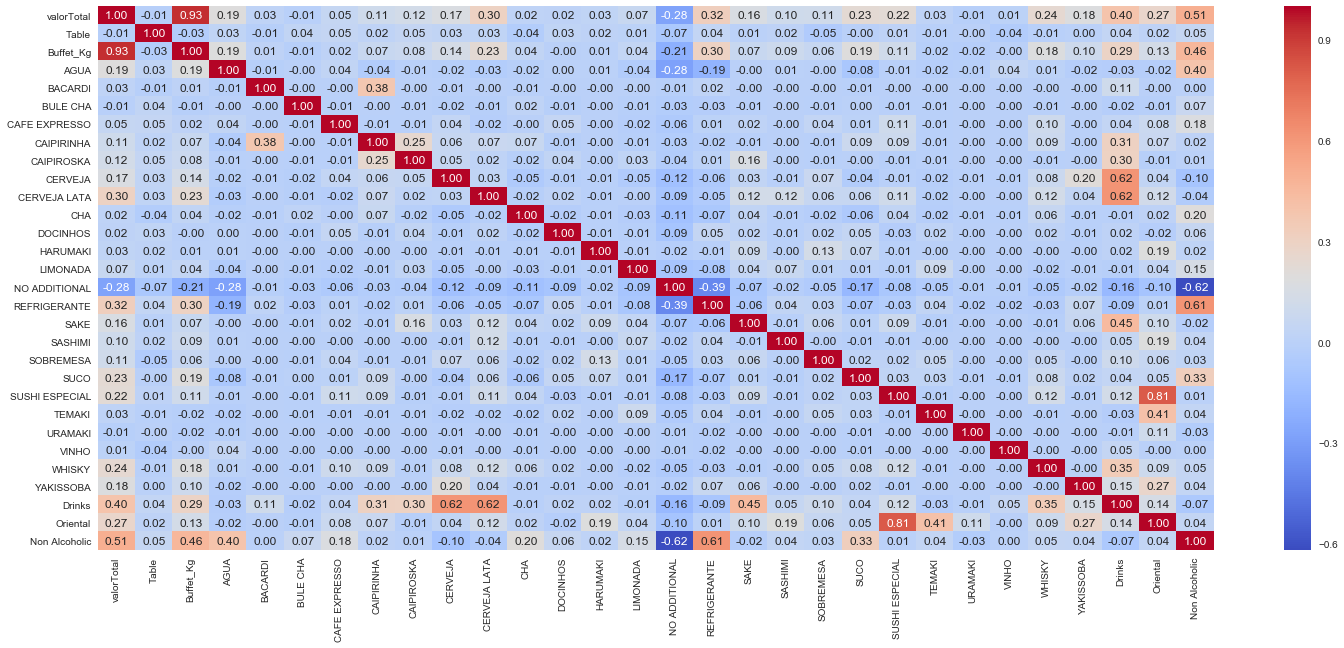

In [24]:
sns.set(rc={'figure.figsize':(25,10)})
g = sns.heatmap(closedOrders.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [32]:
closedOrders = closedOrders.drop(['Table'], axis=1)

ValueError: labels ['Table'] not contained in axis

In [42]:
X = closedOrders.groupby([closedOrders.index.day,closedOrders.index.hour]).sum()
y = X['valorTotal'].iloc[1::]

In [43]:
X_train= X[X.index.get_level_values(0) <= 20][:-1]
y_train= y[y.index.get_level_values(0) <= 20]

X_test= X[X.index.get_level_values(0) > 20]
y_test= y[y.index.get_level_values(0) > 20]

In [44]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [46]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 29))

X_train = sc.fit_transform(X_train)
y_train = sc.fit_transform(y_train)
X_test = sc.fit_transform(X_test)
y_test = sc.fit_transform(y_test)

ValueError: Expected 2D array, got 1D array instead:
array=[1452.09  236.43  105.63  295.85  419.2  1487.19 1695.58 1265.75 1909.33
  374.72  127.3  1052.52 1621.12  894.84  402.04 1298.39 1577.7   349.86
 1403.31 1128.9   518.22   60.56  958.7  1832.96  421.32   57.19  477.37
 1386.06  521.71   53.33  265.52 1002.51 2030.19  216.12  757.86 1324.92
  403.21  270.74  199.95 1158.56 1150.16  970.56  209.71 1113.68 2487.81
  412.53   67.78  703.07 1103.19 1701.44 1649.18  713.29 1260.47 1974.8
 1300.46 1564.85   99.87  948.34 1787.8   660.93  134.64  665.33 1255.83
  446.14   11.93  436.06 1001.68 1321.5   859.51   68.16  687.84 1570.02
  114.29  226.89  724.97  655.35 1069.32 1243.28  310.15 1095.94 1850.02
  356.94  100.99  232.24 1407.89 1338.31 2048.2 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [40]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test= np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#### Model

In [30]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [47]:
def build_model():
        d = 0.2
        model = Sequential()
        model.add(LSTM(50, input_shape=(29,1), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(50,  return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(units = 50, return_sequences = False))
        model.add(Dropout(d))        
        model.add(Dense(1))
        model.compile(loss='mse',optimizer='adam',metrics=['mean_squared_error'])
        return model

In [48]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (87, 29, 1)
y_train (87,)
X_test (17, 29)
y_test (17,)


In [49]:
model = build_model()

In [50]:
model.fit(
    X_train,
    y_train,
    batch_size=32,
    nb_epoch=10,
    validation_split=0.1,
    verbose=2)

Train on 78 samples, validate on 9 samples
Epoch 1/10
 - 4s - loss: 1102532.0321 - mean_squared_error: 1102532.0321 - val_loss: 1430753.6250 - val_mean_squared_error: 1430753.6250
Epoch 2/10
 - 1s - loss: 1102238.0833 - mean_squared_error: 1102238.0833 - val_loss: 1430199.2500 - val_mean_squared_error: 1430199.2500
Epoch 3/10
 - 0s - loss: 1101618.3526 - mean_squared_error: 1101618.3526 - val_loss: 1429080.2500 - val_mean_squared_error: 1429080.2500
Epoch 4/10
 - 0s - loss: 1100557.0721 - mean_squared_error: 1100557.0721 - val_loss: 1427174.3750 - val_mean_squared_error: 1427174.3750
Epoch 5/10
 - 0s - loss: 1098817.3606 - mean_squared_error: 1098817.3606 - val_loss: 1425160.3750 - val_mean_squared_error: 1425160.3750
Epoch 6/10
 - 0s - loss: 1096937.1106 - mean_squared_error: 1096937.1106 - val_loss: 1423618.0000 - val_mean_squared_error: 1423618.0000
Epoch 7/10
 - 0s - loss: 1095638.1058 - mean_squared_error: 1095638.1058 - val_loss: 1422378.7500 - val_mean_squared_error: 1422378.750

In [55]:
y_pred = model.predict(X_test)

In [56]:
y_pred

array([[6.610974 ],
       [6.5997353],
       [6.596025 ],
       [6.591041 ],
       [6.610899 ],
       [6.6109395],
       [6.6158257],
       [6.594793 ],
       [6.591055 ],
       [6.5944877],
       [6.599513 ],
       [6.591219 ],
       [6.590948 ],
       [6.5912905],
       [6.6111436],
       [6.598895 ],
       [6.608321 ]], dtype=float32)